# MSc thesis part 1: main script

### Several functions have been defined and are saved in separate files
### Author: Pim Arendsen

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random
import pickle
import collections
import nbimporter
import cv2
import torch.nn.functional as F
import math
import tqdm

from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, transforms, models
from torch.autograd import Variable
from PIL import Image
from sklearn import linear_model
from sklearn import metrics
from statistics import mean, stdev


#import functions from other files
from p1_CreateTrainingDataframe import CreateTrainingDataframe
from p1_CreateTestDataframe import CreateTestDataframe
from p1_BrodenDataSet import BrodenDataset
from p1_RescaleImage import Rescale
from p1_TransformToTensor import ToTensor
from p1_GetVectorFromImage import GetVector
from p1_GetCosineSimilarityDistance import GetCosineSimilarityDistance
from p1_MakeVectorDictionary import MakeVectorDictionary
from p1_SubsetConceptImages import SubsetConceptImages


Importing Jupyter notebook from p1_CreateTrainingDataframe.ipynb
Importing Jupyter notebook from p1_CreateTestDataframe.ipynb
Importing Jupyter notebook from p1_BrodenDataSet.ipynb
Importing Jupyter notebook from p1_RescaleImage.ipynb
Importing Jupyter notebook from p1_TransformToTensor.ipynb
Importing Jupyter notebook from p1_GetVectorFromImage.ipynb
Importing Jupyter notebook from p1_GetCosineSimilarityDistance.ipynb
Importing Jupyter notebook from p1_MakeVectorDictionary.ipynb
Importing Jupyter notebook from p1_SubsetConceptImages.ipynb


In [2]:
print(os.path.exists('/raid/data/datasets/broden1_384'))
print(os.getcwd())

True
/raid/home/arend036/msc_pim/Thesis-Scripts


## Part 1.1: Download a pretrained ResNet50 and edit the last layers

Download a pretrained model and define the layer from which to extract the image vectors. For the ResNet50 model, the last layer before the fully connected layer is used which is the average pooling layer

In [3]:
basenet = models.resnet50(pretrained=True, progress=True)
out_layer = basenet._modules.get('avgpool')

## Part 1.2: Define the concepts in the Broden dataset

In this thesis the Broden dataset is used. This dataset consists out of +/- 63000 images and +/- 1200 different labels. It contains labels like colors, objects, texture, and scenes. All images have pixel labels (every pixel has its own label), therefore images contain more multiple labels. These labels will be used as *concepts* 

Define directories of the different folders. 
Set the working directory and change the directories accordingly

In [4]:
## my own laptop:
# broden_dataset_path = '../data/broden1_384/'

## on guanabana:
broden_dataset_path = '/raid/data/datasets/broden1_384'

index_file_path = os.path.join(broden_dataset_path, 'index.csv')
label_file_path = os.path.join(broden_dataset_path, 'label.csv')

Create training dataset by parsing through the Broden dataset. The output is a dataframe consisting of the image path and the concepts present in the image. The data is already divided into 70% train and 30% test data.<br>
The training data is parsed into 2 datasets:
- the 'original' dataset, with every image containing all its matching labels.
- the filtered dataset, in which all labels which cover less than 3% of the image are removed

The 'original' data has many noisy labels. E.g. if an image contains 5 pixels which show a mountain then the image will get the label moutnain, while the image does not fully represent this concept. Therefore, all labels covering less than 3% of the image are removed, resulting in a 'filtered dataset'. In other words, these are eactly the same images as the unfiltered training dataset, but with less labels.

In [5]:
REBUILD_DATA = False #set a manual flag to prevent rebuilding the data once it is available

In [6]:
if REBUILD_DATA:
    
    # create the training data dataframe
    print('creating training dataset')
    training_data = CreateTrainingDataframe(index_file_path, label_file_path, broden_dataset_path, 0)
    print('writing training data...')    
    training_data.to_csv('../data/training_data.csv', index=False)
    
    #create filtered training data, which does not contain labels which cover less than 3% of an image
    filtered_training_data = CreateTrainingDataframe(index_file_path, label_file_path, broden_dataset_path, 3)
    print('writing filtered training data...')
    filtered_training_data.to_csv('../data/filtered_training_data.csv')
    
    # create the testdata dataframe
    test_data = CreateTestDataframe(index_file_path, label_file_path, broden_dataset_path, 3)
    print('writing test data...')
    test_data.to_csv('../data/test_data.csv', index=False)
    print('Done')


If the training and test data is already available: update the following directories

In [7]:
training_data_path = '../data/training_data.csv'
filtered_training_data_path = '../data/filtered_training_data.csv'
test_data_path = '../data/test_data.csv'

In [8]:
training_data = pd.read_csv(training_data_path, sep=',')
filtered_training_data = pd.read_csv(filtered_training_data_path, sep=',')
test_data = pd.read_csv(test_data_path)

## Part 1.3 Determine CAVs using the Broden dataset


The Broden dataset is converted into a PyTorch Dataset class, which can be used to access indivual images. <br>
The images are rescaled to 224x224 pixels, transformed to tensors and normalized according to the PyTorch documentation. <br>

The dataset returns a dictionary with the following keys: 
- 'image': as ndarray or tensor, depending on the transformation
- 'concept': a list of all the concepts within an image
- 'concept_vector': a one-hot array for each concept in the image

In [9]:
train_broden_dataset = BrodenDataset(csv_file = training_data_path, 
                               data_path = broden_dataset_path, 
                               transform = transforms.Compose([Rescale(224),
                                                              ToTensor(),
                                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                    std=[0.229, 0.224, 0.225])
                                                              ]))

In [10]:
test_broden_dataset = BrodenDataset(csv_file = test_data_path,
                                    data_path = broden_dataset_path, 
                                    transform = transforms.Compose([Rescale(224),
                                                                    ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                         std=[0.229, 0.224, 0.225])
                                                                   ]))

All the images of the Broden dataset are pushed through the ResNet and the tensors are extracted and stored in a dictionary. Two dictionaries are created: one containing the training images and one containing the test images. The filtered training dataset consists out of the same images as the unfiltered training images, so it is not necessary to create a tensor dictionary for this dataset

In [11]:
training_idxs = list(range(len(training_data)))
test_idxs = list(range(len(test_data)))

training_tensors_filename = 'training_tensors.pickle'
test_tensors_filename = ' test_tensors.pickle'

In [12]:
if os.path.exists(os.path.join('../data/', training_tensors_filename)):
    with open(os.path.join('../data/', training_tensors_filename), 'rb') as handle:
        training_tensors = pickle.load(handle)
else:
    training_tensors = MakeVectorDictionary(basenet, 
                                            out_layer, 
                                            train_broden_dataset, 
                                            training_idxs, 
                                            file_name=training_tensors_filename)
    
if os.path.exists(os.path.join('../data/', test_tensors_filename)):
    with open(os.path.join('../data/', test_tensors_filename), 'rb') as handle:
        test_tensors = pickle.load(handle)
else:
    test_tensors = MakeVectorDictionary(basenet,
                                       out_layer,
                                       test_broden_dataset,
                                       test_idxs,
                                       file_name = test_tensors_filename)

---

### TorchCAV

To determine the Concept Activation Vector, a linear classifier needs to be trained between images representing a concept and random counter images (these are images which do not contain the concept of interest). To do this for many concepts a class called TorchCAV is created. An instance can be created for every concept of interest, this offers flexibility to test multiple concepts but als look into a singel concept if necessary.<br>

When an instance is initiated, the number of images represeting a concept and the number of counter images can be chosen. The concept images are chosen from the *filtered* training data to ensure the concept of interest is present in the images. The counter images are selected from the *unfiltered* training data to ensure that the concept of interest is not present in the images.

In [13]:
class BrodenTorchCAV(object):
    
    def __init__(self, concept, num_concept_imgs, num_counter_imgs, training_tensors, test_tensors,
                 training_dataframe, filtered_training_dataframe, test_dataframe, scene_concepts):

        self.concept = concept
        self.num_concept_imgs = num_concept_imgs
        self.num_counter_imgs = num_counter_imgs
        self.training_tensors = training_tensors
        self.test_tensors = test_tensors       
        self.training_dataframe = training_dataframe
        self.filtered_training_dataframe = filtered_training_dataframe
        self.test_dataframe = test_dataframe
        self.scene_concepts = scene_concepts
        
        self.filtered_concept_idxs = []
        self.unfiltered_concept_idxs = []
        self.test_idxs = []
        self.random_concept_idxs = []
        self.random_counter_idxs = []
        self.test_scene_idxs =[]
        self.test_scene_dict = {}
        self.scene_idx = []
        self.test_idxs = []
        self.FN = []
        self.FN_idxs = []
        
        self.lm = None
        self.cav = None
        self.X_test = None
        self.y_test = None
        self.y_predict = None
        self.accuracy = None

        # if the concept of interest is not present in the training data: raise an error
        if self.concept not in list(self.training_dataframe):
            raise ValueError ('%s is not present in the dataset' % self.concept)    
        
    def get_concept_indices(self):
        '''
        Get all the row indices of the images labelled with the concept in the dataframes.
        This is done for the filtered data (which contains a threshold on pixel labels), the unfiltered data and
        the test data.
        '''
        
        self.filtered_concept_idxs = self.filtered_training_dataframe.loc[self.filtered_training_dataframe[self.concept] == 1, 'image'].index.tolist()
        self.unfiltered_concept_idxs = self.training_dataframe.loc[self.training_dataframe[self.concept] == 1, 'image'].index.tolist()            
        self.test_idxs = self.test_dataframe.loc[self.test_dataframe[self.concept] == 1, 'image'].index.tolist()
        
    def get_random_concept_images(self):
        '''
        Get a specified amount of random concept images from the total amount of filtered images. If the needed
        amount if images is not available for the concept, the amount of concept images is changed to the maximum
        available amount of concept images.
        
        The random concept images are extracted from the filtered dataset, as these images will be used to represent the
        concept in the linear classifier a stricter threshold is applied on the labelling
        '''
        
        self.get_concept_indices()
        if self.num_concept_imgs > len(self.filtered_concept_idxs):
            self.num_concept_imgs = len(self.filtered_concept_idxs)
        
        self.random_concept_idxs = random.sample(self.filtered_concept_idxs, self.num_concept_imgs)
        
    def get_random_counter_images(self):
        '''
        Get a specified amount of random counter images which are not labelled with the concept from 
        the unfiltered data. This will ensure that the selected images will not contain the concept at all.
        '''
        
        self.get_concept_indices()
        self.random_counter_idxs = [i for i in range(len(self.training_dataframe)) if i not in self.unfiltered_concept_idxs]
        
        if len(self.random_counter_idxs) < self.num_counter_imgs:
            self.num_counter_imgs = len(self.random_counter_idxs)
        
        self.random_counter_idxs = random.sample(self.random_counter_idxs, self.num_counter_imgs)
        
    def train_lm(self):
        '''
        Train a linear classifier between the concept images and the counter images
        '''
        
        self.get_random_concept_images()
        self.get_random_counter_images()
        
        # concatenate the tensors of the selected concept images into a matrix
        self.concept_tensors = self.training_tensors[str(self.random_concept_idxs[0])].unsqueeze(0)
        for i in range(1, self.num_concept_imgs):
            self.temp_concept_tensor = self.training_tensors[str(self.random_concept_idxs[i])].unsqueeze(0)
            self.concept_tensors = torch.cat((self.concept_tensors, self.temp_concept_tensor),0)
        
        # concatenate the tensors of the selected counter images into a matrix
        self.counter_tensors = self.training_tensors[str(self.random_counter_idxs[0])].unsqueeze(0)
        for i in range(1, self.num_counter_imgs):
            self.temp_counter_tensor = self.training_tensors[str(self.random_counter_idxs[i])].unsqueeze(0)
            self.counter_tensors = torch.cat((self.counter_tensors, self.temp_counter_tensor), 0)
        
        # concatenate all tensors to the same array
        self.X = torch.cat((self.concept_tensors, self.counter_tensors), 0)
        self.X = self.X.numpy()
        
        # create labels for the tensors
        # 1 = concepts, 0 = not concept
        self.y = np.ones(self.num_concept_imgs)
        self.y = np.append(self.y, np.zeros(self.num_counter_imgs))
        
        # fit a linear classifier
        self.lm = linear_model.SGDClassifier()
        self.lm.fit(self.X, self.y)
        
        # the vector of coeffiecients are orthogonal to the decision hyperplane, thus this vector is the CAV
        self.cav = self.lm.coef_
        self.bias = self.lm.intercept_
        
    def create_scene_test_data(self):
        
        '''
        This creates test data for the specified scenes, this is used to test the different parameters.
        (Can be removed in updated versions)
        '''
        for scene in self.scene_concepts:
            self.scene_idx = self.test_dataframe.loc[self.test_dataframe[scene] == 1, 'image'].index.tolist()
            if len(self.scene_idx) > 50:
                self.scene_idx = random.sample(self.scene_idx, 50)
            self.test_scene_dict[scene] = self.scene_idx
            list(map(lambda x: self.test_scene_idxs.append(x), self.scene_idx))
        
        self.X_scene_test = self.test_tensors[str(self.test_scene_idxs[0])].unsqueeze(0)
        for i in range(1, len(self.test_scene_idxs)):
            temp_vector = self.test_tensors[str(self.test_scene_idxs[i])].unsqueeze(0)
            self.X_scene_test = torch.cat((self.X_scene_test, temp_vector),0)

        self.X_scene_test = self.X_scene_test.numpy()
        
        # Create labels for test data   
        start_idx = 0
        for key in self.scene_concepts:
            if key == self.concept:
                break
            else:
                start_idx += len(self.test_scene_dict[key])

        end_idx = start_idx + len(self.test_scene_dict[self.concept])+1

        #create the right labels on the right tensors
        self.y_test = np.zeros(len(self.test_scene_idxs))
        self.y_test[start_idx:end_idx] = 1
            
    def create_test_data(self):
        ''' 
        Creates test data. All tensors from the test data are concatenated and saved as a .npy file.
        '''
        
        self.test_idxs = list(self.test_tensors.keys())
        
        if os.path.exists('../data/test_data_matrix.npy'):
            self.X_test = np.load('../data/test_data_matrix.npy')
        else:
            self.X_test = self.test_tensors[self.test_idxs[0]].unsqueeze(0)
            for idx in tqdm.tqdm_notebook(range(1, len(self.test_idxs))):
                self.X_test = torch.cat((self.X_test, self.test_tensors[self.test_idxs[idx]].unsqueeze(0)),0)
        
            self.X_test = self.X_test.numpy()
            np.save('../data/test_data_matrix.npy', self.X_test)
            
        self.y_test = self.test_dataframe[self.concept].values.astype('int')
        
        
    def predict(self):
        '''
        Uses the linear classifier to predict the test data, also calculates the average accuracy.
        Calls the function to create test data
        '''
        
        ## To test on the 'scene concepts' change to X_scene_test and y_scene_test
        # self.create_scene_test_data()
        
        self.create_test_data()
        self.y_pred = self.lm.predict(self.X_test)
        #self.probability = self.lm.predict_proba(self.X_test)
        
        # calculate true negatives and true positives for average accuracy
        self.total_negatives = len(self.y_test[self.y_test == 0])
        self.true_neg = 0
        for i in range(len(self.y_pred)):
            if self.y_pred[i] == 0 and self.y_test[i] == self.y_pred[i]:
                self.true_neg += 1
        
        self.total_positives = len(self.y_test[self.y_test == 1])
        self.true_pos = 0
        for i in range(len(self.y_pred)):
            if self.y_pred[i] == 1 and self.y_test[i] == self.y_pred[i]:
                self.true_pos += 1
        
        self.accuracy = metrics.accuracy_score(self.y_test, self.y_pred)
        self.score = self.lm.score(self.X_test, self.y_test)
        if self.total_negatives != 0 and self.total_positives != 0:
            self.average_accuracy = ((self.true_neg/self.total_negatives) + (self.true_pos/self.total_positives)) / 2
        else:
            self.average_accuracy = self.accuracy
            
    def view_concept_images(self):
        '''
        View the concept images used to train the linear classifier
        '''
        
        if len(self.filtered_concept_idxs) == 0:
            raise ValueError ('No images have been selected yet')
        
        else:
            %matplotlib inline
            dim = math.floor(math.sqrt(len(self.random_concept_idxs))) 
            
            fig = plt.figure(figsize=(12,12))
            ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

            for idx, a in enumerate(ax):
                img = plt.imread(os.path.join('/raid/data/datasets/broden1_384/images/', 
                                              self.filtered_training_dataframe.loc[self.random_concept_idxs[idx], 'image']))
                a.axis('off')
                a.imshow(img)

            fig.subplots_adjust(wspace=0, hspace=0)
            plt.show()
            
    def view_counter_images(self):
        '''
        View the counter images used to train the linear classifier
        ''' 
        
        if len(self.random_counter_idxs) == 0:
            raise ValueError ('No counter images have been selected')
            
        else:
            %matplotlib inline
            dim = math.floor(math.sqrt(len(self.random_counter_idxs)))

            fig = plt.figure(figsize=(12,12))
            ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

            for idx, a in enumerate(ax):
                img = plt.imread(os.path.join('/raid/data/datasets/broden1_384/images/', 
                                              training_data.loc[self.random_counter_idxs[idx], 'image']))
                a.axis('off')
                a.imshow(img)

            fig.subplots_adjust(wspace=0, hspace=0)
            plt.show()
        
        
    def view_FN(self):
        '''
        View the false negative images of the linear classifier
        '''
        
        self.FN = []
        self.FN_idxs = []
        
        for i in range(len(self.y_pred)):
            if self.y_pred[i] == 0 and self.y_test[i] != self.y_pred[i]:
                self.FN.append(i)
        
        self.FN_idxs = list(map(lambda x: self.test_scene_idxs[x], self.FN))
                       
        %matplotlib inline
        dim = math.floor(math.sqrt(len(self.FN_idxs)))

        fig = plt.figure(figsize=(12,12))
        ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

        for idx, a in enumerate(ax):
            img = plt.imread(os.path.join('/raid/data/datasets/broden1_384/images/', 
                                          self.test_dataframe.loc[int(self.FN_idxs[idx]), 'image']))
            a.axis('off')
            a.imshow(img)

        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()
   
    def view_FP(self):
        '''
        View false positive images of the linear classifier
        '''
        
        self.FP = []
        self.FP_idxs = []
        
        for i in range(len(self.y_pred)):
            if self.y_pred[i] == 1 and self.y_test[i] != self.y_pred[i]:
                self.FP.append(i)
        
        self.FP_idxs = list(map(lambda x: self.test_scene_idxs[x], self.FP))
        
        %matplotlib inline
        dim = math.floor(math.sqrt(len(self.FP_idxs)))

        fig = plt.figure(figsize=(12,12))
        ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

        for idx, a in enumerate(ax):
            img = plt.imread(os.path.join('/raid/data/datasets/broden1_384/images/', 
                                          self.test_dataframe.loc[int(self.FP_idxs[idx]), 'image']))
            a.axis('off')
            a.imshow(img)

        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
            
        
        

---

## Part 1.4: Calculate average accuracy for different amounts of concept images

To experiment with CAVs the 'scene' concepts are used, as these images are better classified then other concepts. The following scene concepts have been used to experiment with the different option to get a CAV.

In [14]:
scene_concepts =['street-s', 'mountain_snowy-s', 'highway-s', 'skyscraper-s',  'park-s', 'mountain-s', 'coast-s',
                'beach-s', 'field-cultivated-s', 'valley-s', 'bus_shelter-s', 'hayfield-s', 'hill-s', 'building_facade-s', 
                'pasture-s', 'apartment_building-outdoor-s']

For every scene in the above selected scene-concepts the average accuracy will be calculated using different amounts of images describing the concept. Then, for every amount of images a linear classifier is trained between the image representing the concept and the random counter images. The average accuracy is calculated and stored. This is repeated 10 times for every amount of images. After the full iteration, the average of the average accuracy is calculated and plotted with the standard deviation. 

In [ ]:
scene_instance_dictionary = {}
for scene in tqdm.notebook.tqdm(scene_concepts):
    print(scene)
    
    scene_instance_dictionary[scene] = {'num_imgs' : []}
    
    # loop through different amounts of concept images
    for mm in tqdm.notebook.tqdm([1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]):
        temp_scene = BrodenTorchCAV(scene, mm, 200, training_tensors, test_tensors,
                              training_data, filtered_training_data, test_data, scene_concepts)
        
        temp_scene.get_random_concept_images()
        scene_instance_dictionary[scene]['run' + str(len(temp_scene.random_concept_idxs))] = []
        
        # calculate the accuracy 10 times for the same amount of concept images
        for n in range (10):
            temp_scene = BrodenTorchCAV(scene, mm, 200, training_tensors, test_tensors,
                              training_data, filtered_training_data, test_data, scene_concepts)
        
            temp_scene.train_lm()
            temp_scene.predict()
            scene_instance_dictionary[scene]['num_imgs'].append(len(temp_scene.random_concept_idxs))
            scene_instance_dictionary[scene]['run' + str(len(temp_scene.random_concept_idxs))].append(temp_scene.average_accuracy)
        
        if len(temp_scene.random_concept_idxs) < mm:
            break  

Save the created dictionary

In [18]:
if os.path.exists(os.path.join('../data/', 'scene_accuracies.pickle')):
    with open(os.path.join('../data/', 'scene_accuracies.pickle'), 'rb') as handle:
        scene_instance_dictionary = pickle.load(handle)
else:
    with open(os.path.join('../data/', 'scene_accuracies.pickle'), 'wb') as handle:
        pickle.dump(scene_instance_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

Plot the accuracy and the standard deviation for the different amount of concept images for each *scene* concept

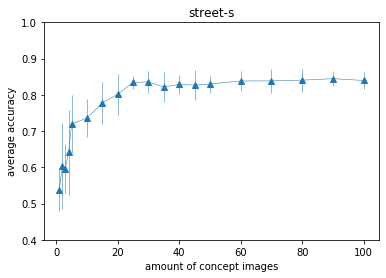

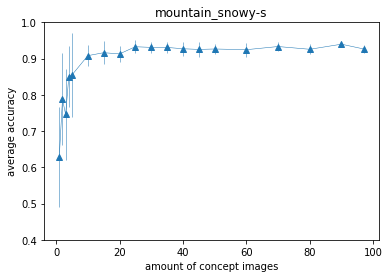

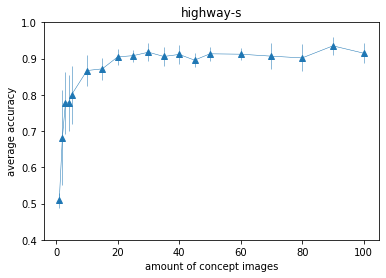

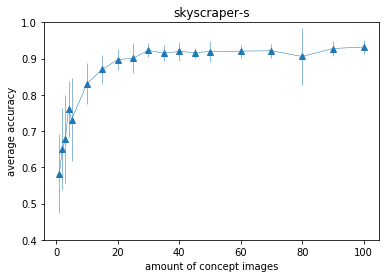

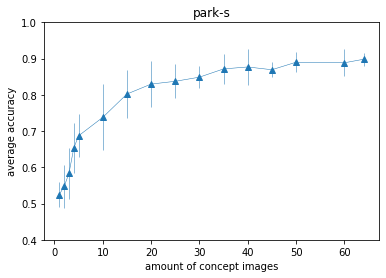

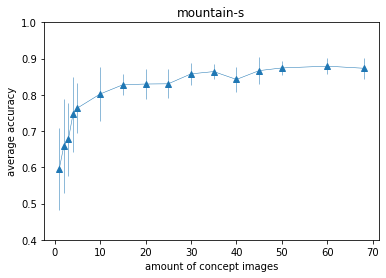

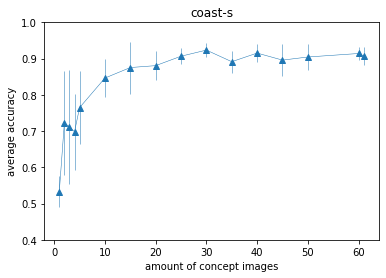

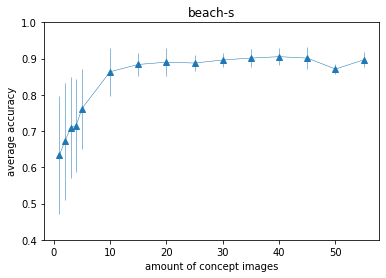

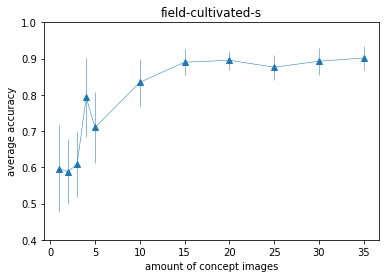

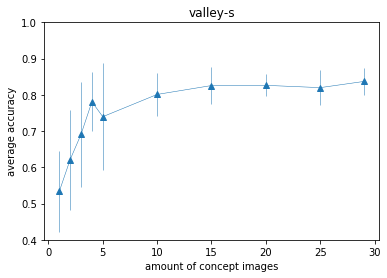

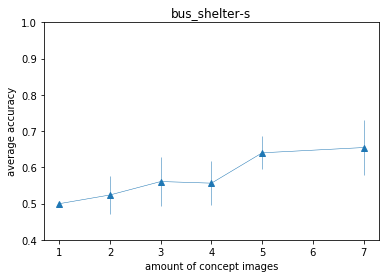

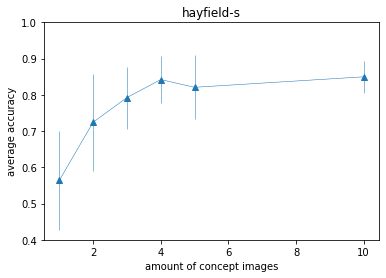

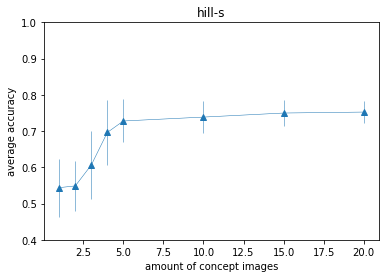

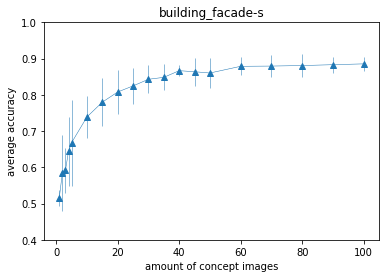

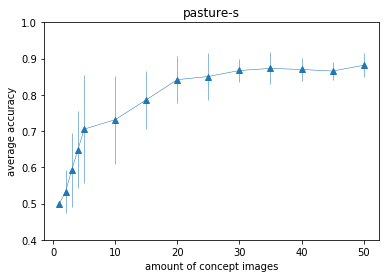

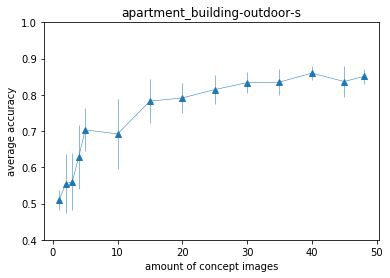

In [19]:
for scene in scene_concepts:
    ys = []
    std_dev = []
    xs = list(collections.OrderedDict.fromkeys(scene_instance_dictionary[scene]['num_imgs']))

    for key in scene_instance_dictionary[scene].keys():
        if key != 'num_imgs':
            ys.append(mean(scene_instance_dictionary[scene][key]))
            std_dev.append(stdev(scene_instance_dictionary[scene][key]))

    plt.errorbar(xs, ys, std_dev, linestyle = 'solid', marker='^', linewidth = 0.5)

    plt.ylim(0.4,1)
    plt.title(scene)
    plt.xlabel('amount of concept images')
    plt.ylabel('average accuracy')
    plt.savefig(os.path.join('../Plots/', scene + '_average_accuracy.png'), bbox_inches='tight')
    plt.show()
    
    

---

## Calculate average accuracy for different amounts of counter images

The same method is applied, but now the amount of counter images is changed. Based on the results from the plots above the amount of concept images is set at 40

In [ ]:
scene_instance_counter_dictionary = {}
for scene in tqdm.notebook.tqdm(scene_concepts):
    print(scene)
    
    scene_instance_counter_dictionary[scene] = {'num_counter_imgs' : []}
    
    for nn in tqdm.notebook.tqdm([1,2,3,4,5,10,15,20,25,30,40,50,75,100,150,200,250,300]):
        scene_instance_counter_dictionary[scene]['run' + str(nn)] = []
        
        for cnt in range(10):
            temp_scene = BrodenTorchCAV(scene, 40, nn, training_tensors, test_tensors,
                                      training_data, filtered_training_data, test_data, scene_concepts)

            temp_scene.train_lm()
            temp_scene.predict()
            scene_instance_counter_dictionary[scene]['num_counter_imgs'].append(nn)
            scene_instance_counter_dictionary[scene]['run' + str(nn)].append(temp_scene.average_accuracy)
        

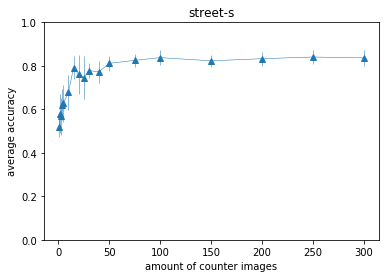

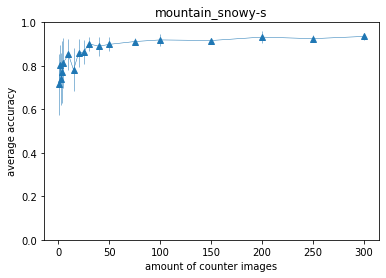

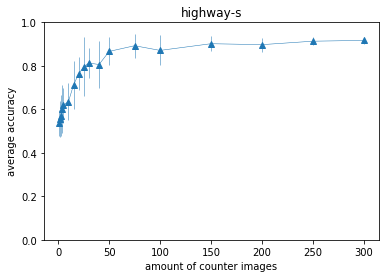

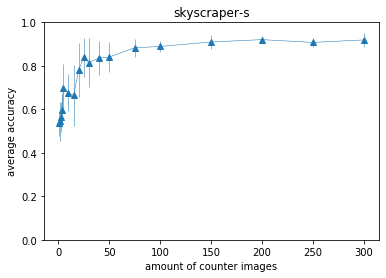

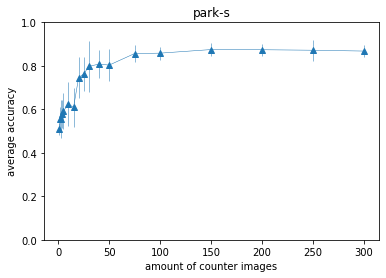

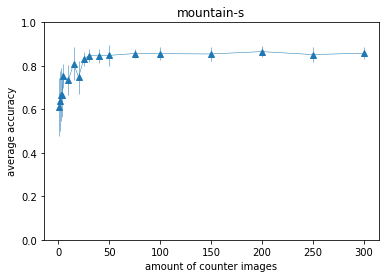

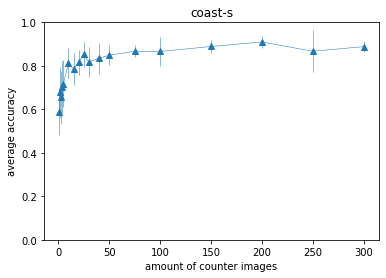

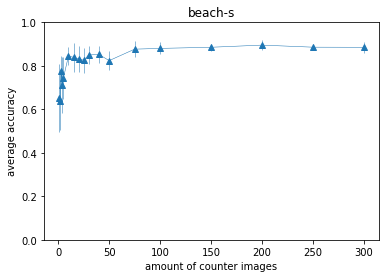

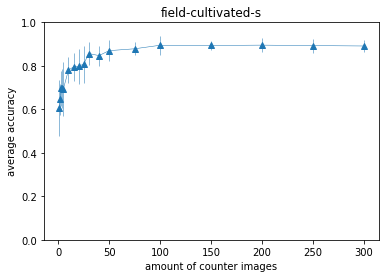

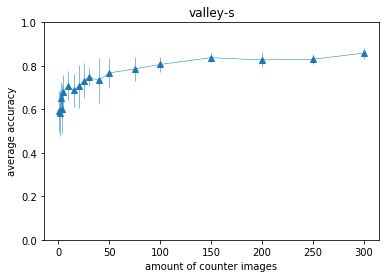

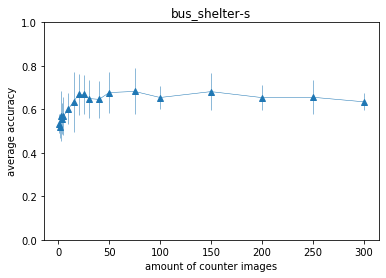

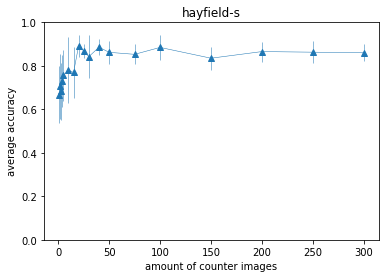

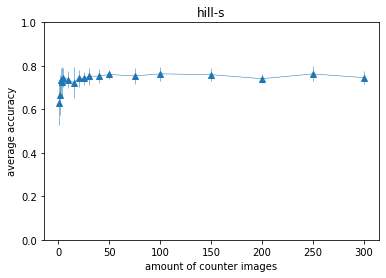

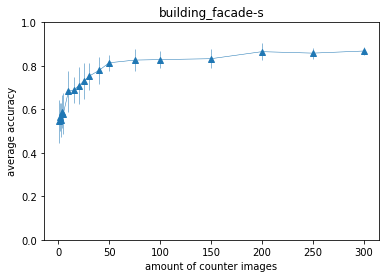

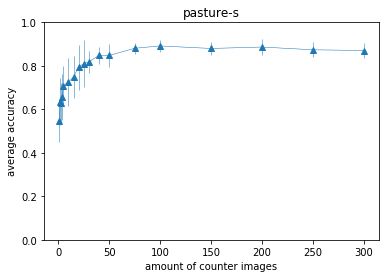

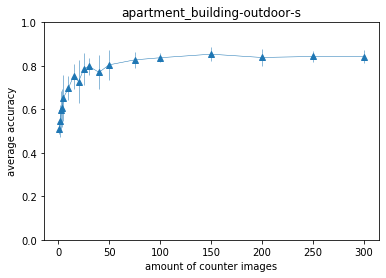

In [58]:
for scene in scene_concepts:
    ys = []
    std_dev = []
    xs = list(collections.OrderedDict.fromkeys(scene_instance_counter_dictionary[scene]['num_counter_imgs']))

    for key in scene_instance_counter_dictionary[scene].keys():
        if key != 'num_counter_imgs':
            ys.append(mean(scene_instance_counter_dictionary[scene][key]))
            std_dev.append(stdev(scene_instance_counter_dictionary[scene][key]))

    plt.errorbar(xs, ys, std_dev, linestyle = 'solid', marker='^', linewidth = 0.5)

    plt.ylim(0,1)
    plt.title(scene)
    plt.xlabel('amount of counter images')
    plt.ylabel('average accuracy')
    plt.savefig(os.path.join('../Plots/', scene + '_counter_imgs_average_accuracy.png'), bbox_inches='tight')
    plt.show()

## Calculate the average accuracy of all concepts in the Broden dataset

In [19]:
concepts_df = pd.read_csv(label_file_path)
concepts = list(concepts_df.name.values)

In [20]:
if os.path.exists(os.path.join('../data/', 'broden_concepts_cavs1.pickle')):
    with open(os.path.join('../data/', 'broden_concepts_cavs.pickle'), 'rb') as handle:
        broden_concept_accuracy = pickle.load(handle)
else:
    removed_concepts = []
    broden_concept_accuracy = {}

    for concept in tqdm.tqdm_notebook(concepts):
        print(concept)

        temp_concept = BrodenTorchCAV(concept, 40, 200, training_tensors, test_tensors, training_data, filtered_training_data,
                               test_data, scene_concepts)
        temp_concept.get_random_concept_images()
        if len(temp_concept.random_concept_idxs) == 0:
            print('concept %s has no images' % concept)
            removed_concepts.append(concept)
            continue
        else:
            broden_concept_accuracy[concept] = {}
            temp_concept.train_lm()
            temp_concept.predict()

            broden_concept_accuracy[concept]['accuracy'] = temp_concept.average_accuracy
            broden_concept_accuracy[concept]['cav'] = temp_concept.cav
            broden_concept_accuracy[concept]['concept_imgs'] = temp_concept.num_concept_imgs
            broden_concept_accuracy[concept]['counter_imgs'] = temp_concept.num_counter_imgs
            broden_concept_accuracy[concept]['bias'] = temp_concept.bias
    
    with open(os.path.join('../data/', 'broden_concepts_cavs.pickle'), 'wb') as handle:
        pickle.dump(broden_concept_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)



    

/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


black-c
grey-c
white-c
brown-c
green-c
pink-c
purple-c
blue-c
yellow-c
red-c
orange-c
wall
sky
floor
windowpane
tree
wood
building
person
painted
head
leg
door
fabric
ceiling
torso
table
arm
eye
concept eye has no images
glass
road
ear
grass
metal
plant
chair
nose
concept nose has no images
car
neck
painting
carpet
hand
sidewalk
wheel
cabinet
light
signboard
mirror
tile
lamp
hair
ground
mouth
concept mouth has no images
curtain
pole
mountain
fence
foot
street-s
streetlight
concept streetlight has no images
bed
eyebrow
concept eyebrow has no images
sofa
handle
concept handle has no images
box
tail
muzzle
earth
plastic-opaque
bottle
paper
shelf
headlight
drawer
water
railing
cushion
book
flower
granite
back
shade
concept shade has no images
bedroom-s
ceramic
rock
seat
paw
vase
pot
flowerpot
sink
column
dog
food
armchair
faucet
concept faucet has no images
wall socket
concept wall socket has no images
body
knob
concept knob has no images
sconce
concept sconce has no images
pillow
base
hea

golf_course-s
patio
ad
price tag
concept price tag has no images
coach roof
hallway-s
controls
island
metal shutters
laundromat-s
ballroom-s
greenhouse-indoor-s
gazebo-exterior-s
market-outdoor-s
subway_interior-s
curtains
porch
bottle rack
concept bottle rack has no images
duck
gas pump
bus_interior-s
doorway-indoor-s
alcove-s
pulpit
ramp
access_road-s
landing_deck-s
archive-s
leaves
slope
helicopter
podium
steering wheel
finger
monument
trailer
gymnasium-indoor-s
waterfall-block-s
windmill
pool
water tower
folding screen
workbench
brushes
leaf
scoreboard
concept scoreboard has no images
cathedral-indoor-s
office_building-s
baggage_claim-s
badlands-s
forest_path-s
home_theater-s
ocean-s
ice rink
carport
gravestone
straw
horse-drawn carriage
tunnel
cannon
tumble dryer
fastfood_restaurant-s
gas_station-s
church-indoor-s
harbor-s
amusement_arcade-s
poolroom-establishment-s
bowling_alley-s
auto_showroom-s
library-indoor-s
restaurant-s
toyshop-s
dentists_office-s
altarpiece
shelter
pond
wi

In [56]:
len(removed_concepts)

106

In [60]:
accuracy_list = 0
for key in broden_concept_accuracy.keys():
    if broden_concept_accuracy[key]['accuracy'] <= 0.75:
        print(key + ': ' + str(broden_concept_accuracy[key]['concept_imgs']))
        accuracy_list += 1


black-c: 40
grey-c: 40
white-c: 40
brown-c: 40
green-c: 40
pink-c: 40
purple-c: 40
blue-c: 40
yellow-c: 40
red-c: 40
wall: 40
floor: 40
windowpane: 40
wood: 40
painted: 40
door: 40
fabric: 40
ceiling: 40
table: 40
glass: 40
painting: 40
carpet: 40
hand: 6
light: 4
mirror: 40
tile: 40
lamp: 5
curtain: 40
pole: 11
foot: 1
tail: 8
earth: 40
headlight: 1
drawer: 13
granite: 40
back: 26
paw: 6
flowerpot: 3
column: 16
pillow: 20
base: 2
headboard: 19
stairs: 40
top: 28
clock: 5
bag: 17
pillar: 40
seat cushion: 14
coffee table: 8
ashcan: 3
basket: 12
living_room-s: 40
pane: 40
double door: 40
television: 2
stairway: 40
cup: 8
van: 14
cap: 1
door frame: 17
poster: 37
flag: 4
drinking glass: 5
towel: 8
frame: 1
rope: 4
plastic-clear: 10
saddle: 3
brick: 40
board: 36
blind: 25
chimney: 8
step: 23
sculpture: 15
engine: 5
wallpaper: 40
loudspeaker: 6
side: 4
pipe: 4
ottoman: 4
jar: 5
pack: 9
minibike: 9
figurine: 1
concrete: 40
wicker: 6
exhaust hood: 3
doorframe: 7
manhole: 3
umbrella: 10
contain

In [61]:
accuracy_list

373

In [24]:
mountain = BrodenTorchCAV('coast-s', 40, 200, training_tensors, test_tensors, training_data, filtered_training_data,
                               test_data, scene_concepts)

In [25]:
mountain.train_lm()

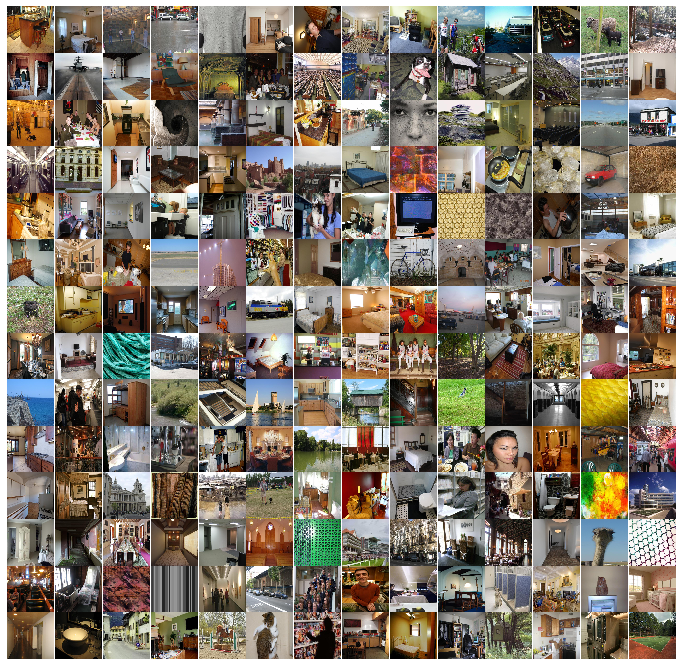

In [27]:
mountain.view_counter_images()